In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import optuna

plt.rcParams['axes.facecolor'] = 'white'

## Data loading and visualization

In [4]:
# load dataset and display it

train_df = pd.read_csv("data/EthanolLevel_TRAIN.tsv", delimiter="\t", header=None)
train_df.rename(columns={0: "Class"}, inplace=True)
train_df

,Class,1,2,3,4,5,6,7,8,9,...,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751
0,1,-0.940664,-0.940862,-0.940825,-0.940935,-0.941051,-0.940899,-0.940626,-0.941078,-0.941991,...,-0.925218,-0.924397,-0.924783,-0.926094,-0.927383,-0.926358,-0.925643,-0.926401,-0.927217,-0.927422
1,1,-0.940462,-0.940467,-0.939796,-0.939806,-0.940126,-0.939963,-0.939673,-0.939822,-0.939965,...,-0.923864,-0.923568,-0.923850,-0.924474,-0.924195,-0.923753,-0.924142,-0.925748,-0.926461,-0.925946
2,1,-0.938836,-0.938843,-0.937838,-0.937874,-0.938608,-0.938350,-0.937995,-0.938506,-0.938726,...,-0.920779,-0.920935,-0.920605,-0.921492,-0.921573,-0.921816,-0.921771,-0.922549,-0.923579,-0.923626
3,1,-0.958735,-0.959072,-0.959191,-0.959089,-0.958887,-0.958532,-0.958515,-0.958836,-0.958921,...,-0.941733,-0.941918,-0.941412,-0.941581,-0.942307,-0.943050,-0.943539,-0.943455,-0.943624,-0.943505
4,1,-0.926828,-0.926971,-0.926971,-0.926981,-0.927062,-0.927174,-0.927174,-0.926930,-0.926666,...,-0.913149,-0.913383,-0.912976,-0.913311,-0.913291,-0.913423,-0.914236,-0.914500,-0.914500,-0.914225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,4,-0.939883,-0.940730,-0.940302,-0.939427,-0.938780,-0.938392,-0.938261,-0.938529,-0.939254,...,-0.920977,-0.921161,-0.920828,-0.920681,-0.920682,-0.921424,-0.921960,-0.922358,-0.922180,-0.921696
500,4,-0.955019,-0.955087,-0.954747,-0.954196,-0.954387,-0.954452,-0.954047,-0.953977,-0.954442,...,-0.935770,-0.936125,-0.935831,-0.935984,-0.936085,-0.936627,-0.937194,-0.936827,-0.936937,-0.936461
501,4,-0.942272,-0.941865,-0.941680,-0.942041,-0.942039,-0.941830,-0.941859,-0.941775,-0.941296,...,-0.922102,-0.922269,-0.922729,-0.922998,-0.922898,-0.922590,-0.923301,-0.923721,-0.924607,-0.924470
502,4,-0.965951,-0.965742,-0.965848,-0.966102,-0.966025,-0.965886,-0.966088,-0.966238,-0.965931,...,-0.945374,-0.945916,-0.946762,-0.946568,-0.946803,-0.945736,-0.947341,-0.947601,-0.948829,-0.947944


In [5]:
# split the train dataframe into train and validation sets
train_df_class = train_df['Class'] - 1
train_df_spectrum = train_df.drop("Class", axis=1)

train_set_spectrum, val_set_spectrum, train_set_class, val_set_class = train_test_split(train_df_spectrum,
                                                                                        train_df_class,
                                                                                        test_size=0.2,
                                                                                        random_state=42)

print(len(train_set_spectrum), len(val_set_spectrum))

403 101


In [6]:
train_set_class.value_counts()

Class
0    107
1    101
2    100
3     95
Name: count, dtype: int64

In [7]:
test_df = pd.read_csv("data/EthanolLevel_TEST.tsv", delimiter="\t", header=None)
test_df.rename(columns={0: "Class"}, inplace=True)
test_set_class = test_df['Class'] - 1
test_set_spectrum = test_df.drop("Class", axis=1)

train_set_class.value_counts()

Class
0    107
1    101
2    100
3     95
Name: count, dtype: int64

In [8]:
import plotly.express as px

label_names = {0: "Class 0 (E35)", 1: "Class 1 (E38)", 2: "Class 2 (E40)", 3: "Class 3 (E45)"}
value_counts = train_set_class.value_counts().reset_index()
value_counts['label'] = value_counts['Class'].map(label_names)
fig = px.pie(value_counts, values='count', names='label', hole=0.5, width=600, height=400)
fig.write_html("pie_chart.html")

In [9]:
def filter_class(spectra, classes, class_to_filter):
    output_spectra = spectra[classes != class_to_filter]
    output_classes = classes[classes != class_to_filter]
    encoder = LabelEncoder()
    encoder.fit(output_classes)
    encoded_classes = encoder.transform(output_classes)
    return output_spectra, encoded_classes

def plot_series(class_n, color, linewidth, title):
    plt.title(title)
    plt.xlabel("Wavelength (conventional units)")
    plt.ylabel("Intensity (conventional units)")
    for obs in train_set_spectrum[train_set_class == class_n].iterrows():
        plt.plot(obs[1], c=color, linewidth=linewidth)
    plt.show()

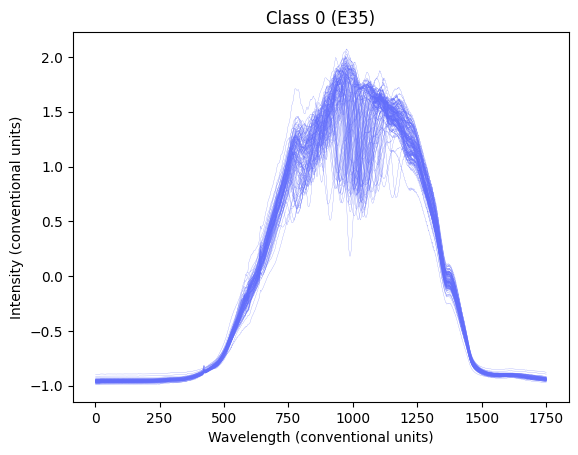

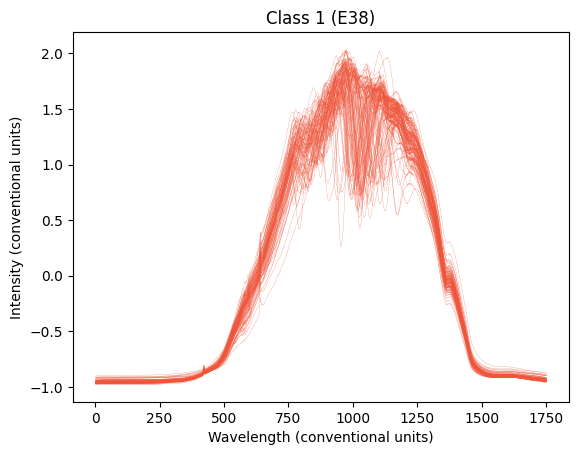

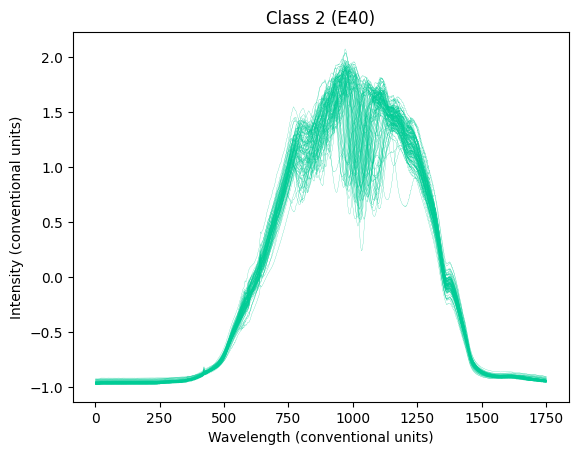

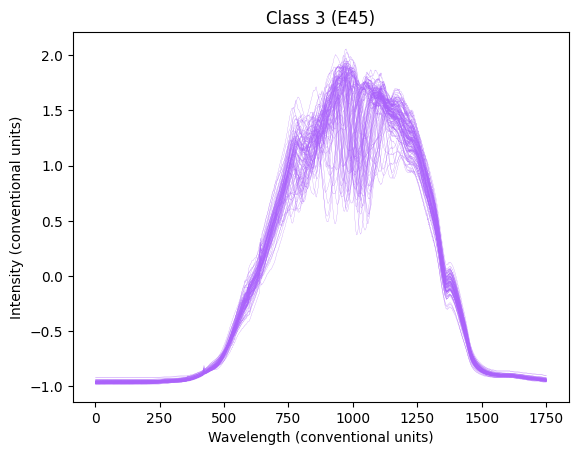

In [10]:
plot_series(0, "#636EFA", 0.15, "Class 0 (E35)")
plot_series(1, "#EF553B", 0.15, "Class 1 (E38)")
plot_series(2, "#00CC96", 0.15, "Class 2 (E40)")
plot_series(3, "#AB63FA", 0.15, "Class 3 (E45)")

## Dimensionality reduction using PCA

In [11]:
pca = PCA(n_components=0.999, random_state=42)
pca.fit(train_set_spectrum)

PCA(n_components=0.999, random_state=42)

Text(0, 0.5, 'Cumulative explained variance ratio')

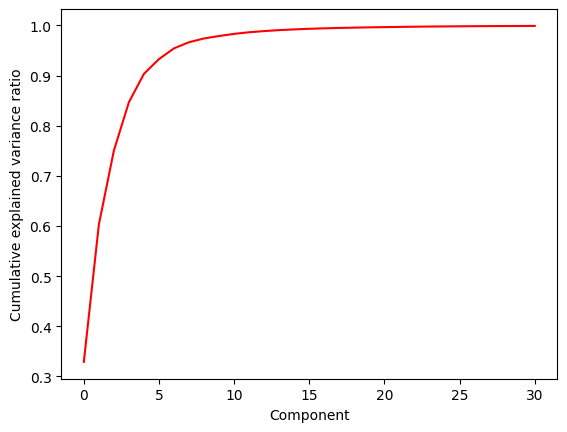

In [12]:
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_explained_variance_ratio, color='red')
plt.xlabel("Component")
plt.ylabel("Cumulative explained variance ratio")

In [13]:
pca.n_components_

31

In [14]:
# transform train, val and test sets
train_set_spectrum_pca = pca.transform(train_set_spectrum)
val_set_spectrum_pca = pca.transform(val_set_spectrum)
test_set_spectrum_pca = pca.transform(test_set_spectrum)

## K Nearest Neighbors classifier

In [15]:
# define KNN classifier model and parameters grid

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20],
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
grid_search_cv = GridSearchCV(estimator=knn_clf,
                              param_grid=knn_param_grid,
                              cv=5,
                              verbose=3,
                              n_jobs=-1)

In [16]:
# fit grid search CV without dimensionality reduction
grid_search_cv.fit(train_set_spectrum, train_set_class)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             verbose=3)

In [17]:
grid_search_cv.best_params_

{'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}

In [18]:
print("Train accuracy: ", grid_search_cv.best_estimator_.score(train_set_spectrum, train_set_class))
print("Val accuracy: ", grid_search_cv.best_estimator_.score(val_set_spectrum, val_set_class))
print("Test accuracy: ", grid_search_cv.best_estimator_.score(test_set_spectrum, test_set_class))

Train accuracy:  0.4441687344913151
Val accuracy:  0.3069306930693069
Test accuracy:  0.278


In [19]:
test_predicts = grid_search_cv.best_estimator_.predict(test_set_spectrum)

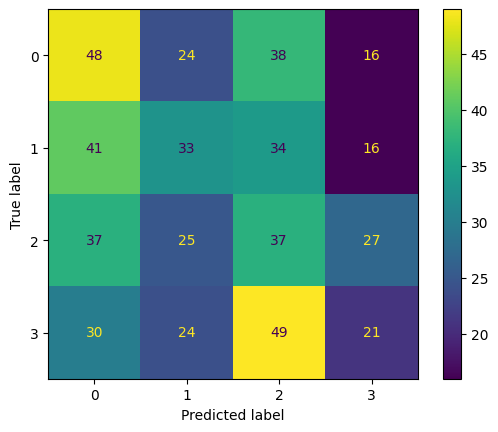

In [20]:
ConfusionMatrixDisplay.from_predictions(y_true=test_set_class, y_pred=test_predicts)

In [21]:
print(classification_report(test_set_class, test_predicts))

              precision    recall  f1-score   support

           0       0.31      0.38      0.34       126
           1       0.31      0.27      0.29       124
           2       0.23      0.29      0.26       126
           3       0.26      0.17      0.21       124

    accuracy                           0.28       500
   macro avg       0.28      0.28      0.27       500
weighted avg       0.28      0.28      0.27       500


In [22]:
grid_search_cv.fit(train_set_spectrum_pca, train_set_class)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             verbose=3)

In [23]:
grid_search_cv.best_params_

{'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}

In [24]:
print("Train accuracy: ", grid_search_cv.best_estimator_.score(train_set_spectrum_pca, train_set_class))
print("Val accuracy: ", grid_search_cv.best_estimator_.score(val_set_spectrum_pca, val_set_class))
print("Test accuracy: ", grid_search_cv.best_estimator_.score(test_set_spectrum_pca, test_set_class))

Train accuracy:  0.5856079404466501
Val accuracy:  0.2871287128712871
Test accuracy:  0.272


## XGBoost classifier

In [27]:
def objective(trial):    
    xgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 200, 250]),
        "max_depth": trial.suggest_categorical("max_depth", [2, 4, 5, 6, 8, 10]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "lambda": trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }
    xgb_classifier = XGBClassifier(tree_method='hist',
                                   verbosity=2,
                                   n_jobs=-1,
                                   eval_metric="merror",
                                   random_state=42,
                                   **xgb_params)

    xgb_classifier.fit(train_set_spectrum, train_set_class)
    
    val_accuracy = xgb_classifier.score(val_set_spectrum, val_set_class)
    return val_accuracy

In [28]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-03-06 13:13:57,136] A new study created in memory with name: no-name-37854f17-b5fb-4282-ad81-2335230a4f13
[I 2024-03-06 13:14:04,323] Trial 0 finished with value: 0.5643564356435643 and parameters: {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.48033526129769255, 'lambda': 0.024903340288832104, 'alpha': 0.0009149180772355337}. Best is trial 0 with value: 0.5643564356435643.
[I 2024-03-06 13:14:59,029] Trial 1 finished with value: 0.48514851485148514 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.039826747317304116, 'lambda': 1.2030299558401082e-08, 'alpha': 0.0008928729758268507}. Best is trial 0 with value: 0.5643564356435643.
[I 2024-03-06 13:15:16,123] Trial 2 finished with value: 0.5445544554455446 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.3383714766915352, 'lambda': 1.8770312634684384e-05, 'alpha': 0.0014281595882320894}. Best is trial 0 with value: 0.5643564356435643.
[I 2024-03-06 13:16:07,174] Trial 3 fin

In [37]:
study.best_params

{'n_estimators': 50,
 'max_depth': 4,
 'learning_rate': 0.3918565812781963,
 'lambda': 2.1047701731285405e-06,
 'alpha': 1.173281031633446e-06}

In [34]:
xgb_classifier = XGBClassifier(tree_method='hist',
                               verbosity=2,
                               n_jobs=-1,
                               eval_metric="merror",
                               random_state=42,
                               **study.best_params)
xgb_classifier.fit(train_set_spectrum, train_set_class)

XGBClassifier(alpha=1.173281031633446e-06, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=2.1047701731285405e-06, learning_rate=0.3918565812781963,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=-1, ...)

In [36]:
print("Train accuracy: ", xgb_classifier.score(train_set_spectrum, train_set_class))
print("Val accuracy: ", xgb_classifier.score(val_set_spectrum, val_set_class))
print("Test accuracy: ", xgb_classifier.score(test_set_spectrum, test_set_class))

Train accuracy:  1.0
Val accuracy:  0.6039603960396039
Test accuracy:  0.536


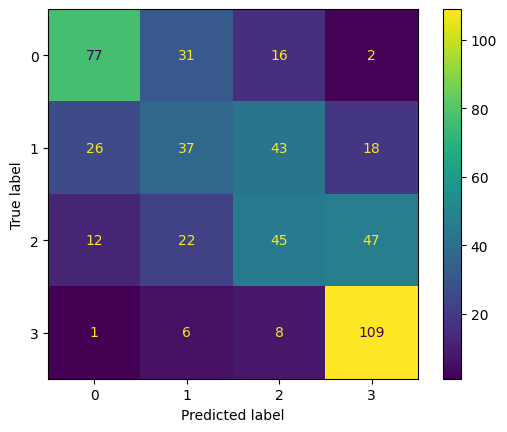

In [38]:
ConfusionMatrixDisplay.from_predictions(y_true=test_set_class, y_pred=xgb_classifier.predict(test_set_spectrum))

In [40]:
print(classification_report(y_true=test_set_class, y_pred=xgb_classifier.predict(test_set_spectrum), digits=3))

              precision    recall  f1-score   support

           0      0.664     0.611     0.636       126
           1      0.385     0.298     0.336       124
           2      0.402     0.357     0.378       126
           3      0.619     0.879     0.727       124

    accuracy                          0.536       500
   macro avg      0.518     0.536     0.519       500
weighted avg      0.518     0.536     0.519       500


In [41]:
def objective(trial):    
    xgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 200, 250]),
        "max_depth": trial.suggest_categorical("max_depth", [2, 4, 5, 6, 8, 10]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "lambda": trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }
    xgb_classifier = XGBClassifier(tree_method='hist',
                                   verbosity=2,
                                   n_jobs=-1,
                                   eval_metric="merror",
                                   random_state=42,
                                   **xgb_params)

    xgb_classifier.fit(train_set_spectrum_pca, train_set_class)
    
    val_accuracy = xgb_classifier.score(val_set_spectrum_pca, val_set_class)
    return val_accuracy

In [42]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-03-06 22:31:13,705] A new study created in memory with name: no-name-b52f94ed-39d0-4234-8699-8968a4511dce
[I 2024-03-06 22:31:16,776] Trial 0 finished with value: 0.6534653465346535 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.025570485048361166, 'lambda': 1.4780271446769575e-05, 'alpha': 4.630835928883285e-06}. Best is trial 0 with value: 0.6534653465346535.
[I 2024-03-06 22:31:17,252] Trial 1 finished with value: 0.693069306930693 and parameters: {'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.3574103703608039, 'lambda': 5.247557947234468e-07, 'alpha': 0.032882284815020736}. Best is trial 1 with value: 0.693069306930693.
[I 2024-03-06 22:31:17,998] Trial 2 finished with value: 0.6633663366336634 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.32052424104578886, 'lambda': 0.00010368692559880504, 'alpha': 2.6482365135727507e-06}. Best is trial 1 with value: 0.693069306930693.
[I 2024-03-06 22:31:18,292] Trial 3 fini

In [43]:
study.best_params

{'n_estimators': 250,
 'max_depth': 4,
 'learning_rate': 0.18142583402324855,
 'lambda': 0.0010484011385045074,
 'alpha': 0.002879829806652731}

In [44]:
xgb_classifier = XGBClassifier(tree_method='hist',
                               verbosity=2,
                               n_jobs=-1,
                               eval_metric="merror",
                               random_state=42,
                               **study.best_params)
xgb_classifier.fit(train_set_spectrum_pca, train_set_class)

XGBClassifier(alpha=0.002879829806652731, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.0010484011385045074, learning_rate=0.18142583402324855,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=-1, ...)

In [45]:
print("Train accuracy: ", xgb_classifier.score(train_set_spectrum_pca, train_set_class))
print("Val accuracy: ", xgb_classifier.score(val_set_spectrum_pca, val_set_class))
print("Test accuracy: ", xgb_classifier.score(test_set_spectrum_pca, test_set_class))

Train accuracy:  1.0
Val accuracy:  0.7326732673267327
Test accuracy:  0.598


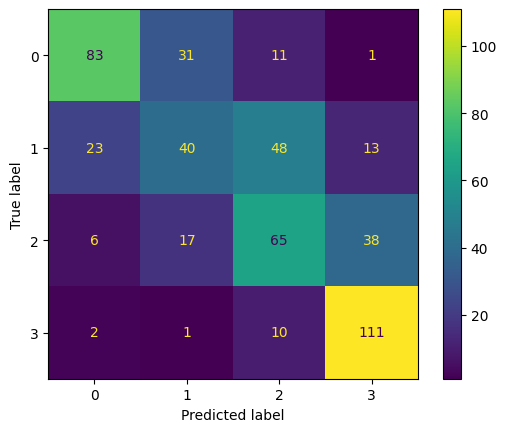

In [50]:
ConfusionMatrixDisplay.from_predictions(y_true=test_set_class, y_pred=xgb_classifier.predict(test_set_spectrum_pca))
plt.show()

In [48]:
print(classification_report(y_true=test_set_class, y_pred=xgb_classifier.predict(test_set_spectrum_pca), digits=3))

              precision    recall  f1-score   support

           0      0.728     0.659     0.692       126
           1      0.449     0.323     0.376       124
           2      0.485     0.516     0.500       126
           3      0.681     0.895     0.774       124

    accuracy                          0.598       500
   macro avg      0.586     0.598     0.585       500
weighted avg      0.586     0.598     0.585       500
